# Project 5: Identify Fraud from Enron Email

### 1. Data Exploration

Before we move to feature selection, I took a look at the data to identify outliers that we should get rid of. I found a record with much larger *salary* and *bonus* values than other records. It turns out that this record belongs to "TOTAL", which is the sum of all individual records and we should ignore in our study. This record of "TOTAL" is removed. In addition, I also noticed a person with *shared_receipt_with_poi* larger than *to_messages* of him by 1. I considered this as a small data issue and decided to make *shared_receipt_with_poi* equal to *to_messages*.

Person with strange email information:  GLISAN JR BEN F
shared_receipt_with_poi is:  874.0
to_messages is:  873.0


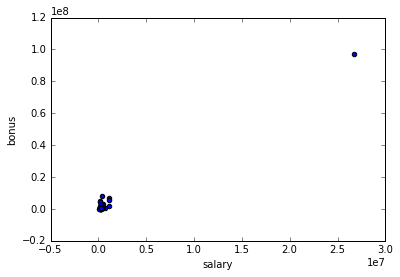

Person with salary higher than 10 million: 	TOTAL


In [41]:
import sys
import pickle
import math
from matplotlib import pyplot
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data


with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

""" scatterplot salary and bonus """
for person in data_dict:
    # read person's information
    data_point = data_dict[person]
    salary = float(data_point['salary'])
    bonus = float(data_point['bonus'])
    shared_receipt_with_poi = float(data_point['shared_receipt_with_poi'])
    to_messages = float(data_point['to_messages'])
    
    # find people with strange email data
    if shared_receipt_with_poi > to_messages:
        print "Person with strange email information: ", person
        print "shared_receipt_with_poi is: ", shared_receipt_with_poi
        print "to_messages is: ", to_messages

    # scatterlpot salary and bonus
    pyplot.scatter( salary, bonus )

pyplot.xlabel("salary")
pyplot.ylabel("bonus")
pyplot.show()

""" find out the outlier """
for person in data_dict:
    data_point = data_dict[person]
    if float(data_point['salary']) > 10000000:
        print "Person with salary higher than 10 million: \t",person

""" remove the outlier """ 
data_dict.pop( 'TOTAL', 0 );

""" correct email data """
data_dict['GLISAN JR BEN F']['shared_receipt_with_poi'] = data_dict['GLISAN JR BEN F']['to_messages']

### 2. Feature Selection

Based on the features we have in the dataset, I go ahead and create several new features as listed below:
* ratio of emails sent from poi to this person compared to total emails sent to this person (*ratio_from_poi_to_this_person*): *from_poi_to_this_person* / *to_messages*
* ratio of emails sent to poi from this person compared to total emails sent from this person (*ratio_from_this_person_to_poi*): *from_this_person_to_poi* / *from_messages*
* ratio of emails that this person shared with poi as recipients compared to total emails sent to this person (*ratio_shared_receipt_with_poi*): *shared_receipt_with_poi* / *to_messages*
* ratio of total stock value to total payments (*ratio_stock_to_payments*): *total_stock_value* / *total_payments*

Firstly, I created the first three ratios because they are are more meaningful than the absolute number of emails sent to or received from POIs. Secondly, I created the fourth ratio because POIs may have higher stock-to-payment ratio than non-POIs since this ratio is comparable between employees with higher payments and those with lower payments.

In [42]:
for person in data_dict:
    
    # read dataset information
    data_point = data_dict[person]
    
    from_poi_to_this_person = float(data_point['from_poi_to_this_person'])
    shared_receipt_with_poi = float(data_point['shared_receipt_with_poi'])
    to_messages = float(data_point['to_messages'])
    
    from_this_person_to_poi = float(data_point['from_this_person_to_poi'])
    from_messages = float(data_point['from_messages'])
    
    total_stock_value = float(data_point['total_stock_value'])
    total_payments = float(data_point['total_payments'])

    # create new features
    if math.isnan(from_poi_to_this_person) or math.isnan(to_messages) or to_messages == 0:
        ratio_from_poi_to_this_person = 0
    else:
        ratio_from_poi_to_this_person = from_poi_to_this_person / to_messages
    
    if math.isnan(from_this_person_to_poi) or math.isnan(from_messages) or from_messages == 0:
        ratio_from_this_person_to_poi = 0
    else:
        ratio_from_this_person_to_poi = from_this_person_to_poi / from_messages
    
    if math.isnan(shared_receipt_with_poi) or math.isnan(to_messages) or to_messages == 0:
        ratio_shared_receipt_with_poi = 0
    else:
        ratio_shared_receipt_with_poi = shared_receipt_with_poi / to_messages
    
    if math.isnan(total_stock_value) or math.isnan(total_payments) or total_payments == 0:
        ratio_stock_to_payments = 0
    else:
        ratio_stock_to_payments = total_stock_value / total_payments
    
    # save new features
    data_point['ratio_from_poi_to_this_person'] = ratio_from_poi_to_this_person
    data_point['ratio_from_this_person_to_poi'] = ratio_from_this_person_to_poi
    data_point['ratio_shared_receipt_with_poi'] = ratio_shared_receipt_with_poi
    data_point['ratio_stock_to_payments'] = ratio_stock_to_payments

Before we move to the the next step, I noticed that many people do not have email information. I decided to save 
would only keep several features from all original and derived features for our study. The reason for doing so is that we don't want to overfit the model and avoid the complexity of choosing from similar features. The features I keep are salary, bonus, total_stock_value, ratio_from_poi, ratio_to_poi, and ratio_shared_with_poi. These features are scaled by the Min/Max Scaler in Sklearn.

In [ ]:
for person in data_dict:
    data_point = data_dict[person]
    if math.isnan(float(data_point['to_messages'])) and math.isnan(float(data_point['from_messages'])):
        data_point['to_messages'] = '-1'
        data_point['from_messages'] = '-1'

features_list = ['poi',
                 'salary', 'deferral_payments', 
                 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value',
                 'expenses', 'exercised_stock_options',
                 'other', 'long_term_incentive',
                 'restricted_stock', 'director_fees',
                 'to_messages', 'from_poi_to_this_person',
                 'from_messages', 'from_this_person_to_poi',
                 'shared_receipt_with_poi',
                 'ratio_from_poi_to_this_person', 'ratio_from_this_person_to_poi',
                 'ratio_shared_receipt_with_poi', 'ratio_stock_to_payments'
                ]
data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
forest.fit(features, labels)
importances = forest.feature_importances_
for f in range(len(features[0])):
    print("%s) %f" % (features_list[f+1], importances[f]))

### 3. Algorithm Selection

In [49]:
print len(features)

145


In [76]:
from sklearn.decomposition import RandomizedPCA

from sklearn import metrics
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

pca = RandomizedPCA(n_components=3, whiten=True).fit(features_train)
features_train = pca.transform(features_train)
features_test = pca.transform(features_test)
    
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()
labels_nb = clf_nb.fit(features_train, labels_train).predict(features_test)
print('Naive Bayes:')
print(metrics.classification_report( labels_test, labels_nb ))

from sklearn import svm
clf_svm = svm.SVC(kernel="rbf", C=10)
labels_svm = clf_svm.fit(features_train, labels_train).predict(features_test)
print('SVM:')
print(metrics.classification_report( labels_test, labels_svm ))

from sklearn import tree
clf_tree = tree.DecisionTreeClassifier(min_samples_split=10)
labels_tree = clf_tree.fit(features_train, labels_train).predict(features_test)
print('Decision Tree:')
print(metrics.classification_report( labels_test, labels_tree ))

Naive Bayes:
             precision    recall  f1-score   support

        0.0       0.90      0.97      0.94        39
        1.0       0.50      0.20      0.29         5

avg / total       0.86      0.89      0.86        44

SVM:
             precision    recall  f1-score   support

        0.0       0.91      1.00      0.95        39
        1.0       1.00      0.20      0.33         5

avg / total       0.92      0.91      0.88        44

Decision Tree:
             precision    recall  f1-score   support

        0.0       0.90      0.95      0.92        39
        1.0       0.33      0.20      0.25         5

avg / total       0.84      0.86      0.85        44



### 4. Algorithm Tuning

### 5. Model Validation

### 6. Model Evaluation

146
salary 339288
to_messages 7259
deferral_payments NaN
total_payments 10425757
exercised_stock_options 4158995
bonus 8000000
restricted_stock 1008149
shared_receipt_with_poi 3962
restricted_stock_deferred NaN
total_stock_value 5167144
expenses 49537
loan_advances NaN
from_messages 2585
other 1552
from_this_person_to_poi 411
poi False
director_fees NaN
deferred_income NaN
long_term_incentive 2035380
email_address john.lavorato@enron.com
from_poi_to_this_person 528


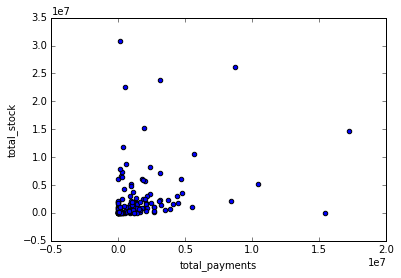

142
144


In [6]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from matplotlib import pyplot

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'bonus',
                 'total_payments', 'total_stock_value',
                 'to_messages', 'from_this_person_to_poi',
                 'from_messages', 'from_poi_to_this_person',
                 'shared_receipt_with_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

print len(data_dict)
### Task 2: Remove outliers

for s in data_dict['LAVORATO JOHN J']:
    print s, data_dict['LAVORATO JOHN J'][s]
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

if 'TOTAL' in my_dataset:
    del my_dataset['TOTAL']
if 'LAY KENNETH L' in my_dataset:
    del my_dataset['LAY KENNETH L']


person_list = []
for s in my_dataset:
    person_list.append(s)
person_list.sort()
### Extract features and labels from dataset for local testing

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

%matplotlib inline
for point in data:
    total_payments = point[3]
    total_stock = point[4]
    pyplot.scatter( total_payments, total_stock )
pyplot.xlabel("total_payments")
pyplot.ylabel("total_stock")
pyplot.show()

print len(data)
print len(person_list)


### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)